In [9]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, COMMON_STAGES, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix, plot_predictions_on_epoch
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Train model on SAT2 Dataset

In [14]:
set_global_seed(42)
data_path_sat2 = DATA_PATH / "sat2/stage_data_100hz.nc"
dataset_sat2 = xr.load_dataset(data_path_sat2)

In [13]:
dataset_sat2

<xarray.Dataset> Size: 3GB
Dimensions:      (epochs: 2447, channels: 30, samples: 250, participant: 18)
Coordinates:
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 244 245 246 247 248 249
  * participant  (participant) <U3 216B 'S1' 'S10' 'S11' ... 'S7' 'S8' 'S9'
    event_name   (participant, epochs) <U21 4MB '' ... 'high/accuracy/left/3'
    rt           (participant, epochs) float64 352kB nan 0.4092 ... 1.319 1.014
Data variables:
    data         (participant, epochs, channels, samples) float64 3GB nan ......
Attributes:
    sfreq:           102.4
    offset:          0
    lowpass:         33.03225806451613
    highpass:        1.0
    lower_limit_RT:  0.25
    upper_limit_RT:  2.5

In [3]:
shape_topological = False
train_data_sat2, val_data_sat2, test_data_sat2 = split_data_on_participants(
    dataset_sat2, 60, norm_min1_to_1
)

In [4]:
chk_path = Path("../models/sat2_transformer_100hz_sequence_b2b.pt")
checkpoint = load_model(chk_path)
model_kwargs = {
    "d_model": len(train_data_sat2.channels),
    "num_heads": 10,
    "ff_dim": 2048,
    "num_layers": 6,
    "num_classes": len(SAT_CLASSES_ACCURACY),
}
model = Seq2SeqTransformer(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
chk_path = Path("../models/sat2_gru_100hz_negative.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(train_data_sat2.channels),
    "n_samples": len(train_data_sat2.samples),
    "n_classes": len(train_data_sat2.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [28]:
chk_path = Path("../models/sat2_transformer_100hz_negative.pt")
checkpoint = load_model(chk_path)
model_kwargs = {
    "n_features": len(train_data_sat2.channels),
    "n_heads": 6,
    "ff_dim": 128,
    "n_layers": 2,
    "n_samples": 11,
    "n_classes": 5,
}
model = TransformerModel(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [40]:
chk_path = Path("../models/sat2_cnn_100hz_negative.pt")
checkpoint = load_model(chk_path)
model_kwargs = {
    "n_classes": 5,
}
model = SAT1Base(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
train_dataset = SAT1Dataset(
    train_data_sat2, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY
)
# Val and test were not used to train
val_dataset = SAT1Dataset(
    val_data_sat2, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY
)
test_dataset = SAT1Dataset(
    test_data_sat2, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY
)

In [6]:
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [10]:
# LOAD SAT 1 (optional)
data_path_sat1 = DATA_PATH / "sat1/stage_data_100hz.nc"
dataset_sat1 = xr.load_dataset(data_path_sat1)
shape_topological = False
train_data_sat1, val_data_sat1, test_data_sat1 = split_data_on_participants(
    dataset_sat1, 60, norm_min1_to_1
)
train_dataset_sat1 = SAT1Dataset(
    train_data_sat1, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY
)
# Val and test were not used to train
val_dataset_sat1 = SAT1Dataset(
    val_data_sat1, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY
)
test_dataset_sat1 = SAT1Dataset(
    test_data_sat1, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY
)

test_loader_sat1 = DataLoader(
    test_dataset_sat1, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [ ]:
#SAT1
window_size = 11
amount_of_graphs = 10
counter = 0
for batch in test_loader_sat1:
    for epoch, true in zip(batch[0], batch[1]):
        # Change function to support whole sequence
        plot_predictions_on_epoch(epoch, true, SAT_CLASSES_ACCURACY, window_size, model, smoothing=False, sequence=True)
        counter += 1
        if counter >= amount_of_graphs: break
    break

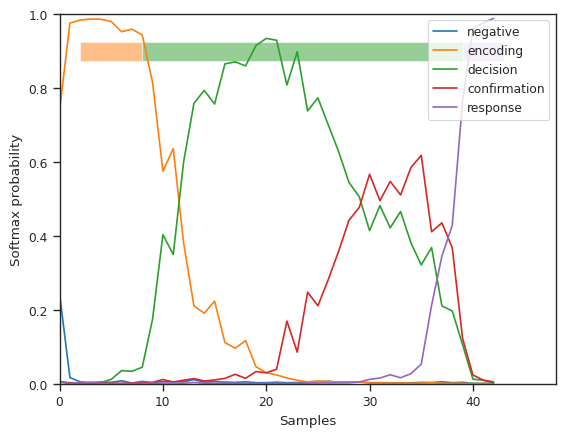

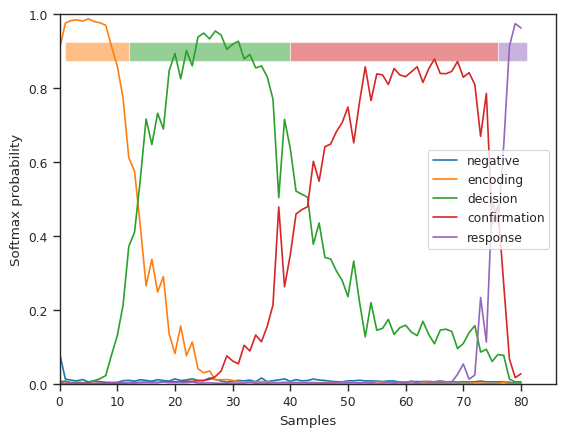

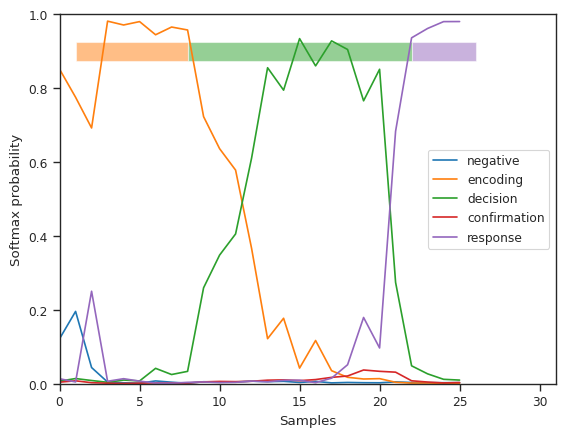

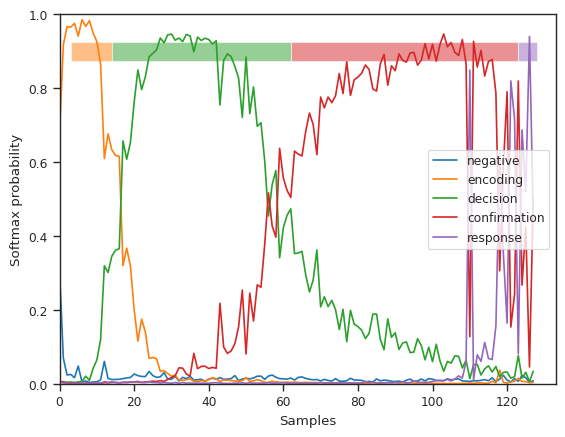

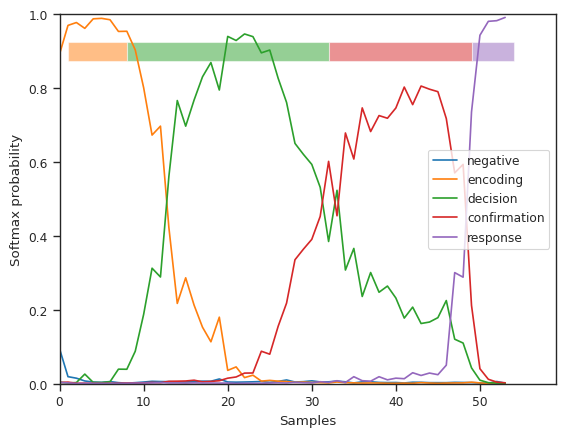

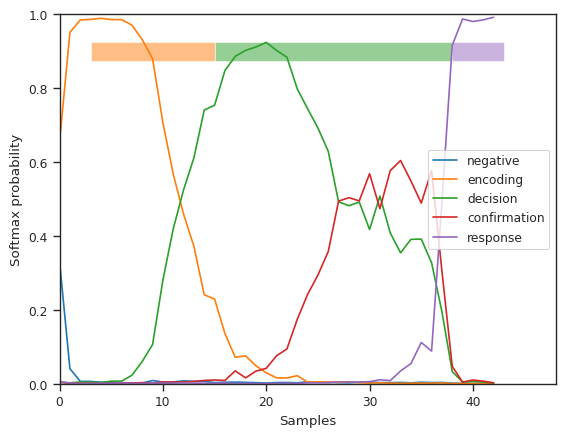

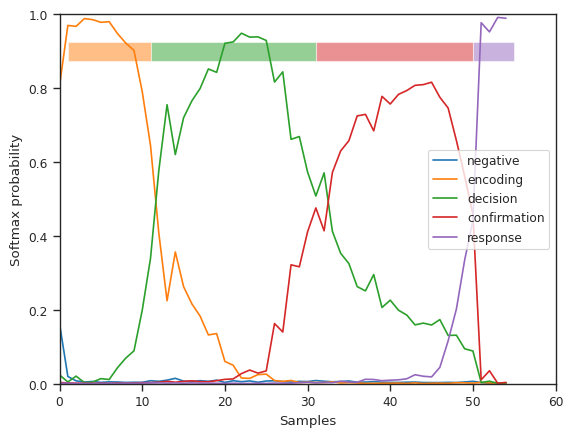

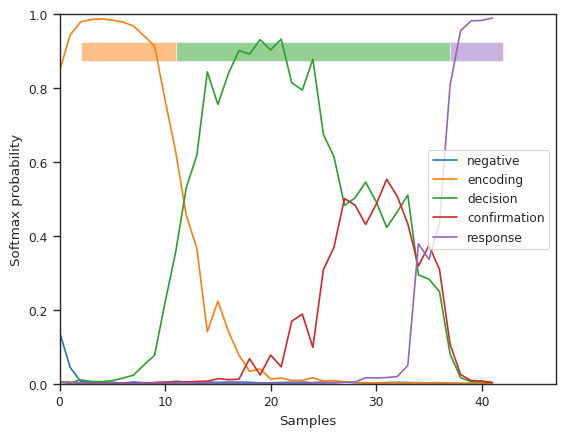

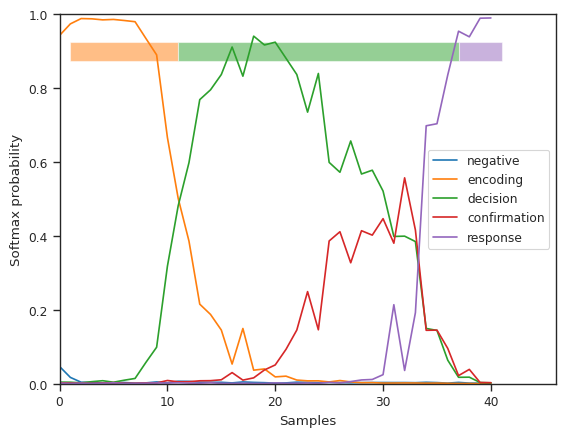

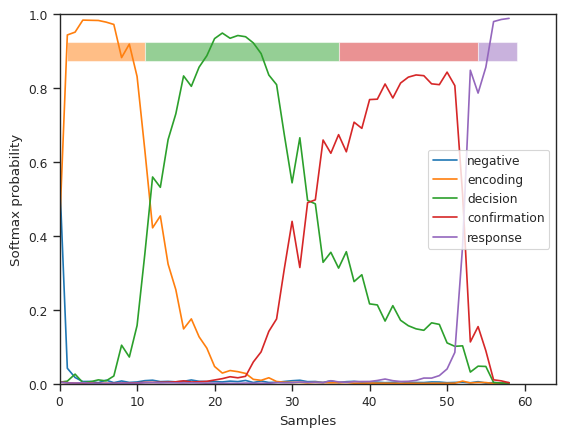

In [17]:
#SAT2
window_size = 11
amount_of_graphs = 10
counter = 0
for batch in test_loader:
    for epoch, true in zip(batch[0], batch[1]):
        # Change function to support whole sequence
        plot_predictions_on_epoch(epoch, true, SAT_CLASSES_ACCURACY, window_size, model, smoothing=False, sequence=True)
        counter += 1
        if counter >= amount_of_graphs: break
    break